In [1]:
from datetime import datetime
from bitarray import bitarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn
import bisect
import copy
import re
import time
from datetime import datetime, timedelta

plt.rcParams["figure.figsize"] = (5,3)

In [2]:
def save_fig(fn):
     plt.tight_layout()
     plt.savefig(fn, metadata={'CreationDate': None})

In [3]:
CONFIG = {}

CONFIG['DATA_FILE'] = "21_03_2022_idle_nodes.txt"

# The data file was generated using the following command (XXX is the user name)
# while true; do date +%s; echo -n "invokers: "; squeue -u XXX -t r -p lowprio -O nodelist -h | gawk '{print $1}' | paste -sd,; sinfo -h -p lowprio | grep idle; echo "----"; sleep 10s; done | tee -a log.txt

CONFIG['DATA_LATER_THAN'] = datetime(2022, 3, 21)
CONFIG['DATE_EARLIER_THAN'] = datetime(2022, 3, 22)

In [4]:
def expand(s):
    r = s.group().split("-")
    l, r = int(r[0]), int(r[1])
    s = []
    for i in range(l, r+1):
        s.append("%04d" % i)
    return ",".join(s)

idleness_records = []
max_node_id = 0

with open(CONFIG['DATA_FILE'], 'r') as log:
    # Read timestamp
    timestamp = log.readline()

    while timestamp:
        # Convert timestamp to integer
        timestamp = int(timestamp)

        ow_nodes = []

        # Read the list of OW invokers
        line = log.readline()
        line = line.split()
        if len(line) > 1:
            ow_nodes = line[1]
            ow_nodes = ow_nodes.split(",")
            ow_nodes = [int(x[1:]) for x in ow_nodes]

            if max(ow_nodes) > max_node_id:
                max_node_id = max(ow_nodes)

        idle_nodes = []

        line = log.readline()
        while line != "----\n":
            # Read the list of nodes
            line = line.split()
            type, record = line[4], line[5]

            # We are only interested in type "idle"
            if type == "idle":
                # Clean the record
                record = record[1:]
                if record[0] == "[":
                    record = record[1:-1]

                # Extract node ids
                record = re.sub("[0-9]{4}-[0-9]{4}", expand, record).split(",")
                idle_nodes = idle_nodes + list(map(lambda x: int(x), record))

                if max(idle_nodes) > max_node_id:
                    max_node_id = max(idle_nodes)
            
            line = log.readline()

        # We are only interested in certain timestamps
        if timestamp >= int(time.mktime(CONFIG['DATA_LATER_THAN'].timetuple())) and timestamp < int(time.mktime(CONFIG['DATE_EARLIER_THAN'].timetuple())):
            idleness_records.append({
                "timestamp" : datetime.fromtimestamp(timestamp),
                "idle_nodes" : idle_nodes,
                "ow_nodes" : ow_nodes
            })

        # Read the next timestamp
        timestamp = log.readline()

In [5]:
CONFIG['DATA_WIDTH'] = len(idleness_records)
CONFIG['DATA_HEIGHT'] = max_node_id + 1 # Some of the nodes were never idle in the measured period, so this number is less than the number of all the nodes in the cluster
CONFIG['MEASURE_DISTANCE'] = (idleness_records[-1]["timestamp"] - idleness_records[0]["timestamp"]).total_seconds() / (CONFIG['DATA_WIDTH'] - 1)

CONFIG['DATA_WIDTH'], CONFIG['DATA_HEIGHT'], CONFIG['MEASURE_DISTANCE']

(8091, 2296, 10.679357231149567)

In [6]:
RESOURCES = {}

In [7]:
# Convert df to a list of idle intervals
RESOURCES['initial_node_status'] = {}

# Create empty bitarrays for all nodes
for node in range(CONFIG['DATA_HEIGHT']):
    RESOURCES['initial_node_status'][node] = bitarray(CONFIG['DATA_WIDTH'])
    RESOURCES['initial_node_status'][node].setall(0)

for timepoint in range(CONFIG['DATA_WIDTH']):
    for node in idleness_records[timepoint]["idle_nodes"]:
        RESOURCES['initial_node_status'][node][timepoint] = 1
    for node in idleness_records[timepoint]["ow_nodes"]:
        RESOURCES['initial_node_status'][node][timepoint] = 1

In [8]:
RESOURCES['total_number_of_measurements'] = CONFIG['DATA_WIDTH'] * CONFIG['DATA_HEIGHT']
RESOURCES['total_number_of_measurements__busy'] = sum([RESOURCES['initial_node_status'][node].count(0) for node in range(CONFIG['DATA_HEIGHT'])])
RESOURCES['total_number_of_measurements__idle'] = \
    RESOURCES['total_number_of_measurements'] - RESOURCES['total_number_of_measurements__busy']
RESOURCES['share_of_measurements__busy'] = \
    RESOURCES['total_number_of_measurements__busy'] / RESOURCES['total_number_of_measurements']
RESOURCES['share_of_measurements__idle'] = \
    RESOURCES['total_number_of_measurements__idle'] / RESOURCES['total_number_of_measurements']

In [9]:
RESOURCES['share_of_measurements__idle']

0.0032133393795403076

# Question 1

## How many nodes are free at each measurement?

In [10]:
MID_RESULTS = {}
MID_RESULTS['number_of_free_nodes_each_point'] = \
    [sum(item) for item in zip(*[RESOURCES['initial_node_status'][node] for node in range(CONFIG['DATA_HEIGHT'])])]

In [11]:
print(np.quantile(MID_RESULTS['number_of_free_nodes_each_point'], 0.25))
print(np.quantile(MID_RESULTS['number_of_free_nodes_each_point'], 0.5))
print(np.quantile(MID_RESULTS['number_of_free_nodes_each_point'], 0.75))
print(np.mean(MID_RESULTS['number_of_free_nodes_each_point']))
print(MID_RESULTS['number_of_free_nodes_each_point'].count(0) / CONFIG["DATA_WIDTH"])

3.0
6.0
10.0
7.377827215424546
0.09442590532690644


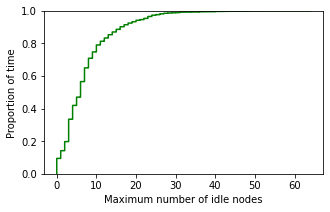

In [12]:
s = seaborn.ecdfplot(MID_RESULTS['number_of_free_nodes_each_point'], color = 'green')
s.set(xlabel='Maximum number of idle nodes', ylabel='Proportion of time')
pass

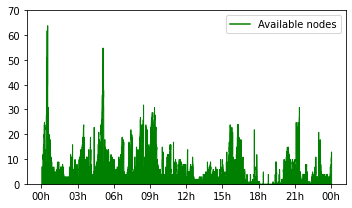

In [13]:
_, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Hh'))
ax.set_ylim(0, 70)

plt.plot([], [], color='green', label='Available nodes')
plt.stackplot(list(map(lambda x : x["timestamp"], idleness_records)), MID_RESULTS['number_of_free_nodes_each_point'], color = 'green')

plt.legend()
save_fig("02 - Var model analysis - Simulation - Idle nodes TS.pdf")
pass

# Question 2

## How long are the periods of idleness?

In [14]:
def ll(r):
    q = []
    l = 0
    for bit in range(len(r)):
        if r[bit] == 1:
            l += 1
        elif l > 0:
            q.append(l)
            l = 0
    if l > 0:
        q.append(l)
    return q

MID_RESULTS['idleness_periods'] = \
    [item for lst in [ll(RESOURCES['initial_node_status'][node]) for node in range(CONFIG['DATA_HEIGHT'])] for item in lst]   

In [15]:
print(np.quantile(MID_RESULTS['idleness_periods'], 0.25)*CONFIG['MEASURE_DISTANCE'])
print(np.quantile(MID_RESULTS['idleness_periods'], 0.5)*CONFIG['MEASURE_DISTANCE'])
print(np.quantile(MID_RESULTS['idleness_periods'], 0.75)*CONFIG['MEASURE_DISTANCE'])
print(np.mean(MID_RESULTS['idleness_periods']))

42.717428924598266
117.47292954264523
245.62521631644003
29.595438770451164


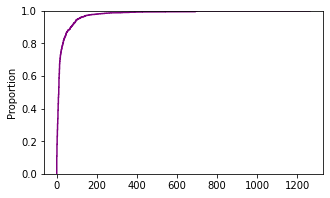

In [16]:
seaborn.ecdfplot(MID_RESULTS['idleness_periods'], color = 'purple')
pass

# Question 3

## Simulation

In [17]:
def find_le(a, x):
    'Find rightmost value less than or equal to x'
    i = bisect.bisect_right(a, x)
    if i:
        return a[i-1]
    raise ValueError

In [18]:
# Worker lengths in minutes
SIMULATION_VARIANTS = {
    "A1" : [2, 4, 6, 8, 14, 22, 34, 56, 90],
    "A2" : [2, 4, 8, 12, 20, 34, 54, 88],
    "A3" : [2, 4, 6, 10, 16, 26, 42, 68, 110],
    "B"  : [2, 4, 8, 16, 32, 64],
    "C1" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    "C2" : [2*i for i in range(1,61)]
}

In [19]:
# Set warmup time (measurements)
WORKER_WARMUP_TIME = 2
SIMULATION_VARIANT = "C2"

# Scaled worker lengths (measurements)
WORKER_LENGTHS = [x*6 for x in SIMULATION_VARIANTS[SIMULATION_VARIANT]]

In [20]:
ms = sum(map(lambda x: max(0, x - WORKER_WARMUP_TIME), MID_RESULTS['idleness_periods']))/RESOURCES['total_number_of_measurements__idle']
print("Maximum possible share of idle time used as ready:", ms)

Maximum possible share of idle time used as ready: 0.9361242335913157


In [21]:
MID_RESULTS['simulation'] = {}

In [22]:
import copy
MID_RESULTS['simulation']['availability_status'] = copy.deepcopy(RESOURCES['initial_node_status'])

for node in range(CONFIG['DATA_HEIGHT']):
    MID_RESULTS['simulation']['availability_status'][node] = \
        MID_RESULTS['simulation']['availability_status'][node].tolist()

In [23]:
MID_RESULTS['simulation']['total_warmup_time'] = 0
MID_RESULTS['simulation']['total_ready_time'] = 0
MID_RESULTS['simulation']['total_worker_jobs'] = 0

In [24]:
# Go through all the nodes and simulate the warming up
node_counter = 0
for node in range(CONFIG['DATA_HEIGHT']):
    i = 0
    
    node_counter += 1
    # print("[Simulating node %i/%i]" % (node_counter, CONFIG['DATA_HEIGHT']))
    
    while i < CONFIG['DATA_WIDTH']:
        start_index = i        
        # Find the length of the period of ones
        while i < CONFIG['DATA_WIDTH'] and MID_RESULTS['simulation']['availability_status'][node][i] == 1:
            i += 1
        end_index = i
        i += 1
                
        # If the period has non-zero length
        while end_index - start_index >= min(WORKER_LENGTHS):
            max_container = find_le(WORKER_LENGTHS, end_index - start_index)
            # print("\tFound promising space %i, putting OW job of length %i" % (end_index - start_index, max_container))
            MID_RESULTS['simulation']['availability_status'][node][start_index:(start_index + WORKER_WARMUP_TIME)] = [2] * WORKER_WARMUP_TIME
            MID_RESULTS['simulation']['availability_status'][node][start_index + WORKER_WARMUP_TIME:start_index + max_container] = [3] * (max_container - WORKER_WARMUP_TIME)
            
            MID_RESULTS['simulation']['total_warmup_time'] += WORKER_WARMUP_TIME
            MID_RESULTS['simulation']['total_ready_time'] += (max_container - WORKER_WARMUP_TIME)
            MID_RESULTS['simulation']['total_worker_jobs'] += 1
            
            start_index += max_container
        
        # if end_index - start_index > 0:
        #     print("\tNode left free for %i ten-second periods [%i, %i)" % (end_index - start_index, start_index, end_index))

In [25]:
print(MID_RESULTS['simulation']['total_warmup_time'])
print(MID_RESULTS['simulation']['total_ready_time'])
print(MID_RESULTS['simulation']['total_worker_jobs'])

1896
48324
948


In [26]:
z = tuple(zip(*[MID_RESULTS['simulation']['availability_status'][node] for node in range(CONFIG['DATA_HEIGHT'])]))
MID_RESULTS['simulation']['status_summary'] = [[item.count(i) for item in z] for i in range(4)]

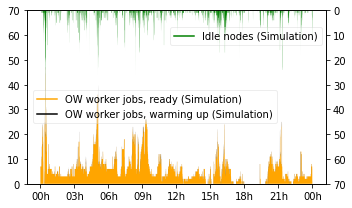

In [27]:
_, ax = plt.subplots()

plt.plot([], [], color='orange', label='OW worker jobs, ready (Simulation)')
plt.plot([], [], color='black', label='OW worker jobs, warming up (Simulation)')
plt.stackplot(list(map(lambda x : x["timestamp"], idleness_records)), [MID_RESULTS['simulation']['status_summary'][3], MID_RESULTS['simulation']['status_summary'][2]], colors=['orange', 'black'])

# handles, labels = ax.get_legend_handles_labels()
# patch = patches.Patch(color='green', label='Idle nodes (Simulation)')
# handles.append(patch) 

ax.legend(loc=(0.02, 0.35), framealpha=0.35)

ax2 = ax.twinx()
ax2.set_ylim(0, 70)
ax2.invert_yaxis()

plt.plot([], [], color='green', label='Idle nodes (Simulation)')
plt.stackplot(list(map(lambda x : x["timestamp"], idleness_records)), MID_RESULTS['simulation']['status_summary'][1], colors=['green'])

ax2.legend(loc=(0.48, 0.8), framealpha=0.35)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Hh'))
ax.set_ylim(0, 70)
plt.xticks(rotation = 90)

save_fig("02 - Var model analysis - Simulation - Node statuses TS.pdf")
pass

In [28]:
print(np.quantile(MID_RESULTS['simulation']['status_summary'][3], 0.25))
print(np.quantile(MID_RESULTS['simulation']['status_summary'][3], 0.5))
print(np.quantile(MID_RESULTS['simulation']['status_summary'][3], 0.75))
print(np.mean(MID_RESULTS['simulation']['status_summary'][3]))

3.0
4.0
8.0
5.972562106043752


In [29]:
print(np.quantile(MID_RESULTS['simulation']['status_summary'][2], 0.25))
print(np.quantile(MID_RESULTS['simulation']['status_summary'][2], 0.5))
print(np.quantile(MID_RESULTS['simulation']['status_summary'][2], 0.75))
print(np.mean(MID_RESULTS['simulation']['status_summary'][2]))

0.0
0.0
0.0
0.2343344456803856


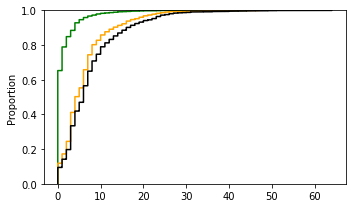

In [30]:
seaborn.ecdfplot(MID_RESULTS['simulation']['status_summary'][1], color = 'green')
seaborn.ecdfplot(list(map(lambda x : MID_RESULTS['simulation']['status_summary'][3][x], range(CONFIG['DATA_WIDTH']))), color = 'orange')
seaborn.ecdfplot(MID_RESULTS['number_of_free_nodes_each_point'], color = 'black')

save_fig("02 - Var model analysis - Simulation - Node statuses CDF.pdf")
pass

In [31]:
print("Share of idle time used as ready:", MID_RESULTS['simulation']['total_ready_time']/RESOURCES['total_number_of_measurements__idle'])
print("Share of idle time used as warmup:", MID_RESULTS['simulation']['total_warmup_time']/RESOURCES['total_number_of_measurements__idle'])
print("Share of idle time not used:", 1 - (MID_RESULTS['simulation']['total_warmup_time'] + MID_RESULTS['simulation']['total_ready_time'])/RESOURCES['total_number_of_measurements__idle'])
print("Number of measurements where no OW worker was ready:", MID_RESULTS['simulation']['status_summary'][3].count(0))
print("Share of time where no OW worker was ready:", MID_RESULTS['simulation']['status_summary'][3].count(0)/CONFIG['DATA_WIDTH'])
print("Average number of ready nodes: ", (MID_RESULTS['simulation']['total_ready_time']/RESOURCES['total_number_of_measurements__idle']) * (sum(MID_RESULTS['number_of_free_nodes_each_point'])/CONFIG['DATA_WIDTH']))

Share of idle time used as ready: 0.8095285958387778
Share of idle time used as warmup: 0.03176198612925922
Share of idle time not used: 0.15870941803196303
Number of measurements where no OW worker was ready: 960
Share of time where no OW worker was ready: 0.11865035224323323
Average number of ready nodes:  5.972562106043752
